In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
import pandas as pd
from IPython.display import clear_output
import requests

import quick_pp.las_handler as las
from quick_pp.qaqc import badhole_flag, mask_outside_threshold, neu_den_xplot_hc_correction
from quick_pp.plotter import plotly_log

In [20]:
with open('X10_raw.las', 'rb') as f:
    df, header, _ = las.read_las_file(f)

# Mask outside threshold
df = mask_outside_threshold(df, True)

# Flag bad hole
df = badhole_flag(df) if 'CALI' in df.columns else df
# Prepare the data for the prediction request.
df.interpolate(inplace=True)  # Interpolate null values
df.dropna(inplace=True)  # Drop remaining null values
clear_output()

# API Request

In [27]:
def make_api_request(df_dict: dict,
                     endpoint: str,
                     session: requests.Session = None,
                     verify: bool = False) -> list:
    """""
    This method sends a prediction request to the FastAPI Swagger UI. It uses the provided DataFrame
    dictionary, field, use case, method, and model to make the request. It also uses the provided session
    and verify flag.

    Args:
        df_dict (dict): The DataFrame dictionary to use for the prediction request.
        field (str): The field to use for the prediction request.
        use_case (str): The use case to use for the prediction request.
        method (str): The method to use for the prediction request.
        model (str): The model to use for the prediction request.
        session (requests.Session, optional): The session to use for the prediction request.
        If not provided, a new session will be created. Defaults to None.
        verify (bool, optional): The verify flag to use for the prediction request.
        If set to False, the SSL certificate will not be verified. Defaults to False.

    Returns:
        list: The prediction result if the request is successful.

    Raises:
        AssertionError: If the first key in the DataFrame dictionary is not "data".
    """
    assert "data" in df_dict.keys()

    # Define model API server to the FastAPI Swagger UI.
    model_server = {
        "local": "http://localhost:8000",
    }

    headers = {
        "Content-Type": "application/json",
        "accept": "application/json",
    }

    try:
        # Create url to access the model API.
        url = f"{model_server['local']}/api/{endpoint}"
        print(f"Requesting API to {url}")

        # Get the response from the API.
        response = session.post(url=url,
                                json=df_dict,
                                headers=headers,
                                verify=verify)
        status = response.status_code

        if status == 200:
            return response.json()
        else:
            print(f"[make_api_request] Error | {response.text} ")

    except Exception as e:
        print(f"[make_api_request] Error | {e} ")


session = requests.Session()

# Lithology

In [34]:
data_dict = {
    "dry_sand_point": [
        -0.02,
        2.65
    ],
    "dry_silt_point": [
        None,
        2.68
    ],
    "dry_clay_point": [
        None,
        2.7
    ],
    "fluid_point": [
        1,
        1
    ],
    "wet_clay_point": [
        None,
        None
    ],
    "method": "kuttan_modified",
    "silt_line_angle": 117,
}

In [57]:
df_dict = pd.DataFrame()
df_dict[['nphi', 'rhob']] = df[['NPHI', 'RHOB']]
df_dict = {"data": df_dict.to_dict(orient="records")}  # Convert data_df to dictionary
df_dict.update(data_dict)

# Make the prediction request via API.
api_data_response = make_api_request(df_dict=df_dict, endpoint='ssc', session=session)
df_ssc = df.copy()
df_ssc[['VSAND', 'VSILT', 'VCLW']] = pd.DataFrame(api_data_response)[['VSAND', 'VSILT', 'VCLW']]

Requesting API to http://localhost:8000/api/ssc


In [44]:
fig = plotly_log(df_ssc)
fig.show()
# fig.write_html('plot.html')

## Hydrocarbon Correction

In [71]:
df_dict = pd.DataFrame()
df_dict[['nphi', 'rhob', 'gr']] = df[['NPHI', 'RHOB', 'GR']]
df_dict = {"data": df_dict.to_dict(orient="records")}  # Convert data_df to dictionary
df_dict.update(data_dict)
df_dict.update({'dry_clay_point': (0.33, 2.7), 'corr_angle': 50})

# Make the prediction request via API.
api_data_response = make_api_request(df_dict=df_dict, endpoint='hc_correction', session=session)
df_corr = df.copy()
df_corr[['VSAND', 'VSILT', 'VCLW']] = pd.DataFrame(api_data_response)[['VSAND', 'VSILT', 'VCLW']]

Requesting API to http://localhost:8000/api/hc_correction


In [59]:
fig = plotly_log(df_corr)
fig.show()
# fig.write_html('plot.html')

# Porosity

In [84]:
# df_dict = pd.DataFrame()
# df_dict[['nphi', 'rhob', 'gr']] = df[['NPHI', 'RHOB', 'GR']]
# df_dict = {"data": df_dict.to_dict(orient="records")}  # Convert data_df to dictionary
# df_dict.update(data_dict)
# df_dict.update({'dry_clay_point': (0.33, 2.7), 'corr_angle': 50})

# Make the prediction request via API.
api_data_response = make_api_request(df_dict=df_dict, endpoint='phit/den', session=session)
df_corr['PHID'] = pd.DataFrame(api_data_response)['PHID']

Requesting API to http://localhost:8000/api/phit/den


In [78]:
# Make the prediction request via API.
api_data_response = make_api_request(df_dict=df_dict, endpoint='phit/neu_den', session=session)
df_corr['PHIT'] = pd.DataFrame(api_data_response)['PHIT']

Requesting API to http://localhost:8000/api/phit/neu_den


<Axes: xlabel='DEPTH'>

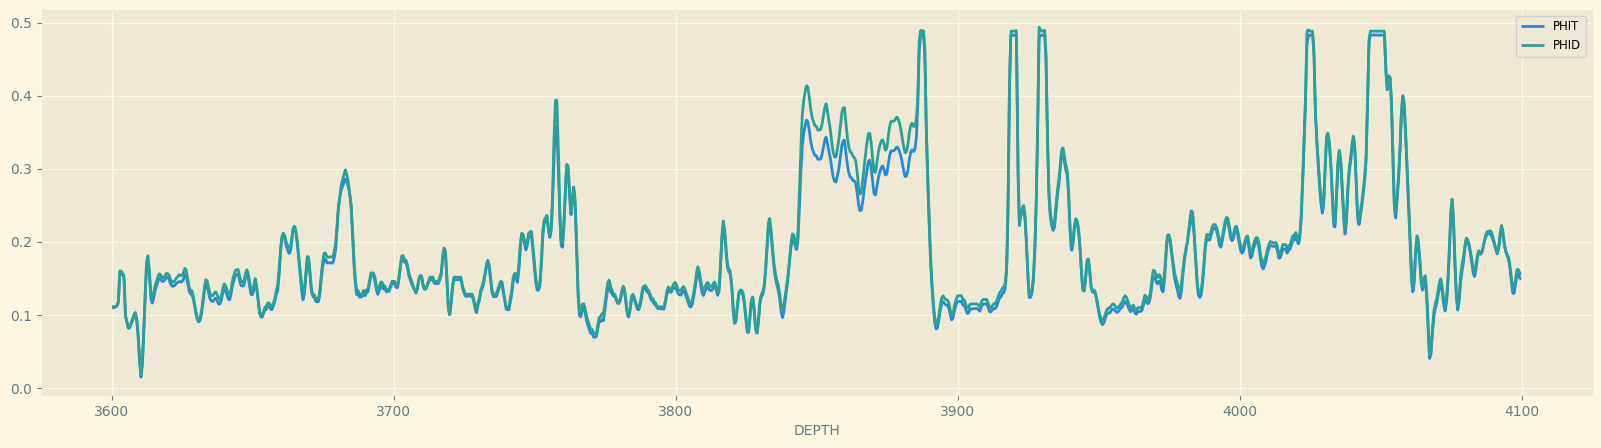

In [85]:
df_corr.plot(x='DEPTH', y=['PHIT', 'PHID'], figsize=(20, 5))

# Water Saturation

In [ ]:
from quick_pp.saturation import *
from quick_pp.plotter import *

In [ ]:
# Waxman-Smits method
temp_grad = estimate_temperature_gradient(df_ssc_hc['DEPTH'] / 7, 'metric')  # Arbitrarily convert MD to TVD
water_salinity = 30000
rw = estimate_rw_temperature_salinity(temp_grad, water_salinity)

b = estimate_b_waxman_smits(temp_grad, rw)

qv = estimate_qv(df_ssc_hc.VCLD, df_ssc_hc.PHIT, cec_clay=.1)
# qv = estimate_qv_hill(df_ssc_model['VCLB'], df_ssc_hc.PHIT, water_salinity)
# qv = estimate_qv_lavers(df_ssc_hc.PHIT)

# m = estimate_m_archie(df_ssc_hc['RT'], rw, df_ssc_hc['PHIT'])
# m = estimate_m_indonesian(df_ssc_hc['RT'], rw, df_ssc_hc['PHIT'], df_ssc_hc['VCLD'], 50)
m = 2

df_ssc_hc['SWT'] = waxman_smits_saturation(df_ssc_hc['RT'], rw, df_ssc_hc['PHIT'], qv, b, m)

# Archie method
df_ssc_hc['SWT_A'] = archie_saturation(df_ssc_hc['RT'], rw, df_ssc_hc['PHIT'], 1, 2, 2)

df_ssc_hc.plot(x='DEPTH', y=['SWT', 'SWT_A'], figsize=(20, 5))

# Permeability

In [ ]:
from quick_pp.permeability import *

In [ ]:
constant = df_ssc_hc['VCLB']**1.75
Swirr = constant / df_ssc_hc['PHIT']
df_ssc_hc['PERM'] = choo_permeability(df_ssc_hc['VCLW'], df_ssc_hc['VSILT'], df_ssc_hc['PHIT'])
df_ssc_hc['PERM_KC'] = kozeny_carman_permeability(df_ssc_hc['PHIT'], Swirr)
df_ssc_hc['PERM_T'] = timur_permeability(df_ssc_hc['PHIT'], Swirr)
df_ssc_hc['PERM_C'] = coates_permeability(df_ssc_hc['PHIT'], Swirr)
df_ssc_hc['PERM_TX'] = tixier_permeability(df_ssc_hc['PHIT'], Swirr)
df_ssc_hc.plot(x='DEPTH', y=['PERM', 'PERM_KC', 'PERM_T', 'PERM_C', 'PERM_TX'], figsize=(20, 5), logy=True)

# Reservoir Summary

In [ ]:
from quick_pp.ressum import *

In [ ]:
df_ssc_hc['ZONES'] = 'ALL'
depth = df_ssc_hc.DEPTH
vshale = df_ssc_hc.VCLW
phit = df_ssc_hc.PHIT
swt = df_ssc_hc.SWT
perm = df_ssc_hc.PERM
zones = df_ssc_hc.ZONES
ressum_df = calc_reservoir_summary(depth, vshale, phit, swt, perm, zones, cutoffs=[0.3, 0.1, .75])
ressum_df

In [ ]:
fig = plotly_log(df_ssc_hc)
fig.show()
# fig.write_html('plot.html')

# Rock Type

In [ ]:
std = df_ssc_hc['VCLW'].describe()['std']
standard_q = [0.05, 0.15, 0.5]
proportion = [pct - std for pct in standard_q]
proportion = standard_q if any([p < 0.15 for p in proportion]) else proportion
q_dict = df_ssc_hc['VCLW'].quantile(proportion).to_dict()
q_dict

In [ ]:
df_ssc_hc['ROCK_TYPE'] = np.where(df_ssc_hc['VCLW'] < list(q_dict.values())[0], 1,
                               np.where(df_ssc_hc['VCLW'] < list(q_dict.values())[1], 2,
                                        np.where(df_ssc_hc['VCLW'] < list(q_dict.values())[2], 3, 4)))

In [ ]:
df_ssc_hc.plot(y='PERM', x='PHIT', logy=True, kind='scatter', figsize=(5, 5), c='ROCK_TYPE', colormap='viridis')